# What files do I need?

You'll need train.csv, test.csv and sample_submission.csv.

# What should I expect the data format to be?

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

# What am I predicting?

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Files

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

# Columns

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)



https://www.kaggle.com/c/nlp-getting-started

In [11]:
import re
import math
import spacy
import random
import string
import spacy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from plotly.offline import init_notebook_mode,iplot
from sklearn.feature_extraction.text import CountVectorizer

# **Training base**

In [12]:
base_train = pd.read_csv('/content/train.csv')
base_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [13]:
base_train.drop(['id', 'keyword', 'location'], axis = 1, inplace=True)
base_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


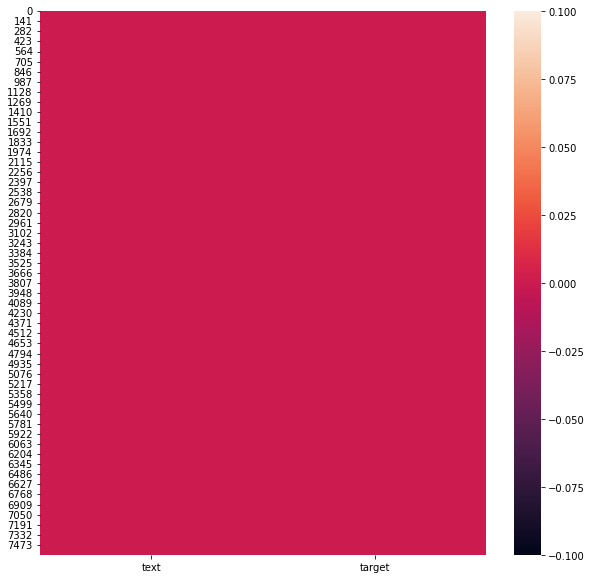

In [14]:
sns.heatmap(pd.isnull(base_train));

(0.0, 4776.200000000001)

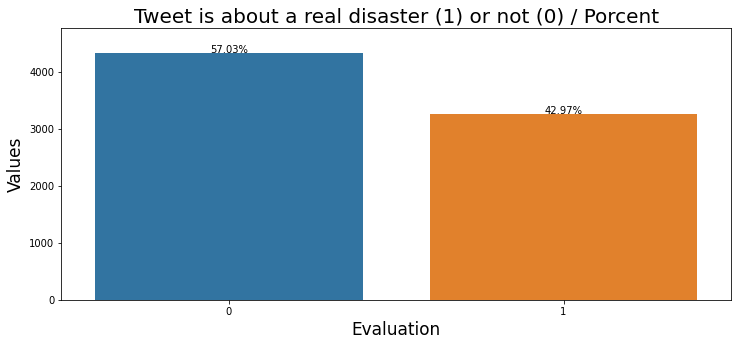

In [15]:
total = len(base_train)
ax1 = plt.figure(figsize=(12,5))

g = sns.countplot(x='target', data=base_train)
g.set_title("Tweet is about a real disaster (1) or not (0) / Porcent", fontsize=20)
g.set_xlabel("Evaluation", fontsize=17)
g.set_ylabel("Values", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
g.set_ylim(0, max(sizes) * 1.1)

In [16]:
Real = base_train[base_train['target'] == 1] 
fake = base_train[base_train['target'] == 0]

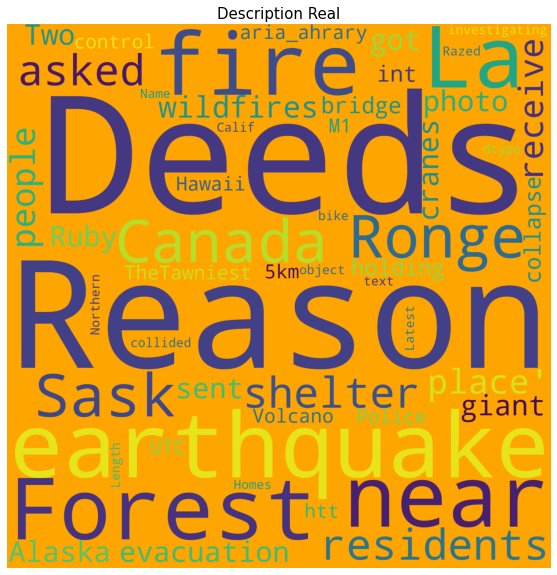

In [17]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(Real['text']))
plt.title('Description Real', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

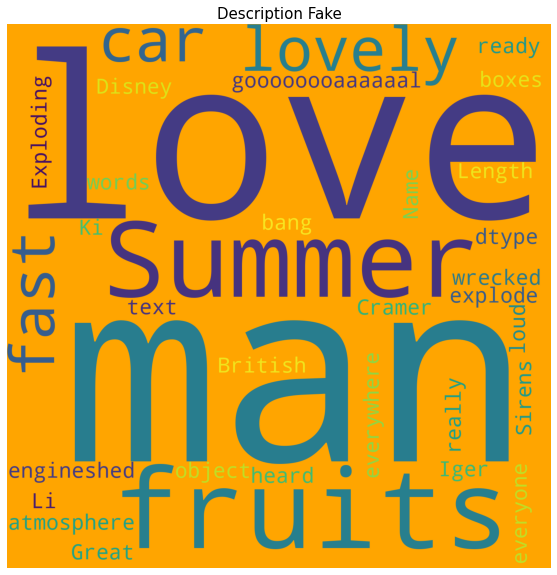

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(fake['text']))
plt.title('Description Fake', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

# BASE DE TEST

In [19]:
base_test = pd.read_csv('/content/test.csv')
base_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [20]:
base_test.drop(['id', 'keyword', 'location'], axis = 1, inplace=True)
base_test

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


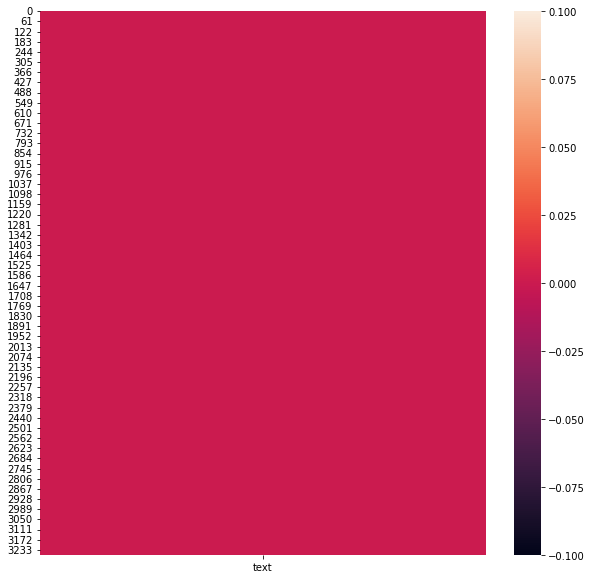

In [21]:
sns.heatmap(pd.isnull(base_test));

# Text pre-processing function

In [22]:
pln = spacy.blank('en')
pln

In [23]:
base_train['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [24]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [25]:
print(stop_words)

{'them', 'latterly', 'sometime', 'the', 'himself', '‘m', 'did', 'whose', 'where', 'only', 'anything', 'something', 'hence', 'it', 'down', 'beyond', 'therein', 'twelve', 'after', 'around', 'say', 'among', 'serious', 'please', '’ll', 'those', 'if', 'was', 'thence', 'your', 'still', 'are', 'else', 'made', 'almost', '‘ll', 'anyone', 'within', 'besides', 'yourself', 'ourselves', 'such', 'am', 'thereby', 'toward', 'nor', 'wherever', 'at', 'with', 'some', 'while', 'a', 'amount', '’d', 'show', 'about', 'had', 'he', 'ten', 'see', 'an', 'any', 'here', 'ours', 'not', 'as', 'first', 'together', 'two', 'becomes', 'sometimes', 'hereafter', 'must', 'when', 'onto', 'least', 'just', 'used', 'should', "'re", 'except', 'more', 'thereupon', 'would', 'mostly', 'whence', 'towards', 'under', 'even', 'what', 'therefore', 'make', 'whole', 'up', 'these', "'s", 'whereas', 'nevertheless', 'fifteen', 'become', 'seems', 'various', 'in', 'you', 'move', '’ve', 'via', 'mine', 'i', 'again', 'back', 'by', 'him', 'sixty'

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def preprocessing(text):
  text = text.lower()
  text = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r" +", ' ', text)
  list_emotions = {':)': 'emotionpositive',
                   ':d': 'emotionpositive',
                   ':(': 'emotionnegative'}
  for emotion in list_emotions:
    text = text.replace(emotion, list_emotions[emotion])

  document = pln(text)

  list = []
  for token in document:
    list.append(token.lemma_)
  
  list = [word for word in list if word not in stop_words and word not in string.punctuation]
  list = ' '.join([str(elemento) for elemento in list if not elemento.isdigit()])
  
  return list

In [29]:
text_test = "hello  @ bye !!#$%"
result = preprocessing(text_test)
result

'hello bye'

# Database pre-processing

In [30]:
base_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [31]:
base_train['text'] = base_train['text'].apply(preprocessing)

In [32]:
base_train

,text,target
0,deeds reason earthquake allah forgive,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7608,giant cranes holding bridge collapse nearby homes,1
7609,control wild fires california northern state...,1
7610,m1.94 01:04 utc]?5 km s volcano hawaii,1
7611,police investigating e bike collided car littl...,1


In [33]:
base_test['text'] = base_test['text'].apply(preprocessing)

In [34]:
base_test

,text
0,happened terrible car crash
1,heard earthquake different cities stay safe
2,forest fire spot pond geese fleeing street save
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills china taiwan
...,...
3258,earthquake safety los angeles ûò safety faste...
3259,storm ri worse hurricane city&amp;3others hard...
3260,green line derailment chicago
3261,meg issues hazardous weather outlook hwo


# Class treatment

In [35]:
base_data_train_final = []
for text, emotion in zip(base_train['text'], base_train['target']):
  if emotion == 1:
    dic = ({'POSITIVE': True, 'NEGATIVE': False})
  elif emotion == 0:
    dic = ({'POSITIVE': False, 'NEGATIVE': True})

  base_data_train_final.append([text, dic.copy()])

In [36]:
len(base_data_train_final)

7613

In [37]:
base_data_train_final[10:15]

[['people died heat wave far', {'NEGATIVE': False, 'POSITIVE': True}],
 ['haha south tampa getting flooded hah- wait second live south tampa fvck flooding',
  {'NEGATIVE': False, 'POSITIVE': True}],
 ['raining flooding florida tampabay tampa days -PRON- lost count',
  {'NEGATIVE': False, 'POSITIVE': True}],
 ['flood bago myanmar arrived bago', {'NEGATIVE': False, 'POSITIVE': True}],
 ['damage school bus multi car crash breaking',
  {'NEGATIVE': False, 'POSITIVE': True}]]

# Creating the classifier

In [43]:
model = spacy.blank('en')
categories = model.create_pipe("textcat")
categories.add_label("POSITIVE")
categories.add_label("NEGATIVE")
model.add_pipe(categories)
historic = []

In [44]:
model.begin_training()
for epoch in range(20):
  random.shuffle(base_data_train_final)
  losses = {}
  for batch in spacy.util.minibatch(base_data_train_final, 512):
    textes = [model(text) for text, entities in batch]
    annotations = [{'cats': entities} for text, entities in batch]
    model.update(textes, annotations, losses=losses)
    historic.append(losses)
  if epoch % 5 == 0:
    print(losses)

{'textcat': 2.669571699698281e-05}
{'textcat': 3.032430257121632e-06}
{'textcat': 2.249861417169541e-06}
{'textcat': 1.9067717289544817e-06}


In [45]:
historic_loss = []
for i in historic:
  historic_loss.append(i.get('textcat'))

In [46]:
historic_loss = np.array(historic_loss)
historic_loss

array([2.66957170e-05, 2.66957170e-05, 2.66957170e-05, 2.66957170e-05,
       2.66957170e-05, 2.66957170e-05, 2.66957170e-05, 2.66957170e-05,
       2.66957170e-05, 2.66957170e-05, 2.66957170e-05, 2.66957170e-05,
       2.66957170e-05, 2.66957170e-05, 2.66957170e-05, 1.62157414e-05,
       1.62157414e-05, 1.62157414e-05, 1.62157414e-05, 1.62157414e-05,
       1.62157414e-05, 1.62157414e-05, 1.62157414e-05, 1.62157414e-05,
       1.62157414e-05, 1.62157414e-05, 1.62157414e-05, 1.62157414e-05,
       1.62157414e-05, 1.62157414e-05, 8.90943096e-06, 8.90943096e-06,
       8.90943096e-06, 8.90943096e-06, 8.90943096e-06, 8.90943096e-06,
       8.90943096e-06, 8.90943096e-06, 8.90943096e-06, 8.90943096e-06,
       8.90943096e-06, 8.90943096e-06, 8.90943096e-06, 8.90943096e-06,
       8.90943096e-06, 5.12901627e-06, 5.12901627e-06, 5.12901627e-06,
       5.12901627e-06, 5.12901627e-06, 5.12901627e-06, 5.12901627e-06,
       5.12901627e-06, 5.12901627e-06, 5.12901627e-06, 5.12901627e-06,
      

Text(0, 0.5, 'Erro')

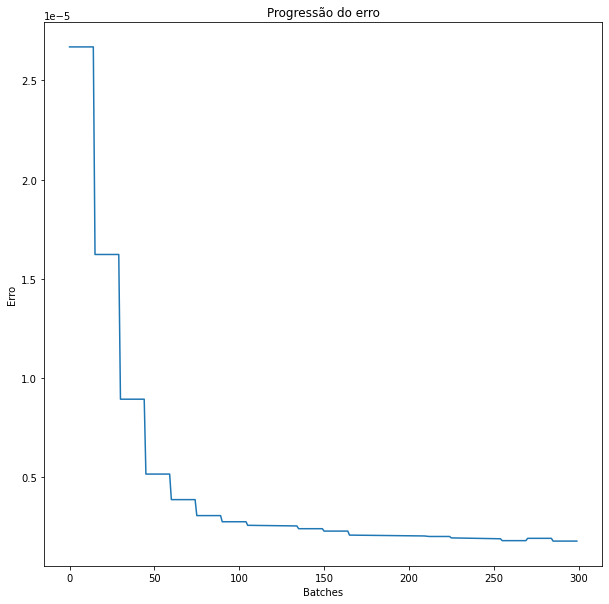

In [48]:
import matplotlib.pyplot as plt
plt.plot(historic_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [58]:
model.to_disk("model")

# One Sentence Tests

In [63]:
model = spacy.load('model')
model


In [70]:
text_positive = base_test['text'][231]
text_positive

'fucking true decapitated throw head avalanche'

In [71]:
forecast = model(text_positive)
forecast

fucking true decapitated throw head avalanche

In [72]:
forecast.cats

{'NEGATIVE': 0.9359604120254517, 'POSITIVE': 0.03581274673342705}

# Avaliação do modelo

# Avaliação na base de treinamento

In [74]:
forecasts = []
for text in base_train['text']:
  forecast = model(text)
  forecasts.append(forecast.cats)

In [75]:
forecasts

[{'NEGATIVE': 0.0016332468949258327, 'POSITIVE': 0.9962969422340393},
 {'NEGATIVE': 0.0017678291769698262, 'POSITIVE': 0.9979693293571472},
 {'NEGATIVE': 0.021459603682160378, 'POSITIVE': 0.9814988970756531},
 {'NEGATIVE': 0.005298747681081295, 'POSITIVE': 0.9957385063171387},
 {'NEGATIVE': 0.008453593589365482, 'POSITIVE': 0.995232880115509},
 {'NEGATIVE': 0.006498103495687246, 'POSITIVE': 0.9901871681213379},
 {'NEGATIVE': 0.0100412517786026, 'POSITIVE': 0.986689031124115},
 {'NEGATIVE': 0.001563857076689601, 'POSITIVE': 0.9978031516075134},
 {'NEGATIVE': 0.04013519734144211, 'POSITIVE': 0.9764233231544495},
 {'NEGATIVE': 0.024690167978405952, 'POSITIVE': 0.9863879680633545},
 {'NEGATIVE': 0.0012451417278498411, 'POSITIVE': 0.9992501139640808},
 {'NEGATIVE': 0.02995075285434723, 'POSITIVE': 0.9595834016799927},
 {'NEGATIVE': 0.0170491524040699, 'POSITIVE': 0.9835198521614075},
 {'NEGATIVE': 0.012043755501508713, 'POSITIVE': 0.9849826693534851},
 {'NEGATIVE': 0.00028866558568552136, '

In [85]:
forecasts_final = []
for forecast in forecasts:
  if forecast['POSITIVE'] > forecast['NEGATIVE']:
    forecasts_final.append(1)
  else:
    forecasts_final.append(0)

forecasts_final = np.array(forecasts_final)

In [86]:
forecasts_final

array([1, 1, 1, ..., 1, 1, 1])

In [87]:
Reals = base_train['target'].values
Reals

array([1, 1, 1, ..., 1, 1, 1])

In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(Reals, forecasts_final)

0.983580717194273

In [89]:
cm = confusion_matrix(Reals, forecasts_final)
cm

array([[4300,   42],
       [  83, 3188]])

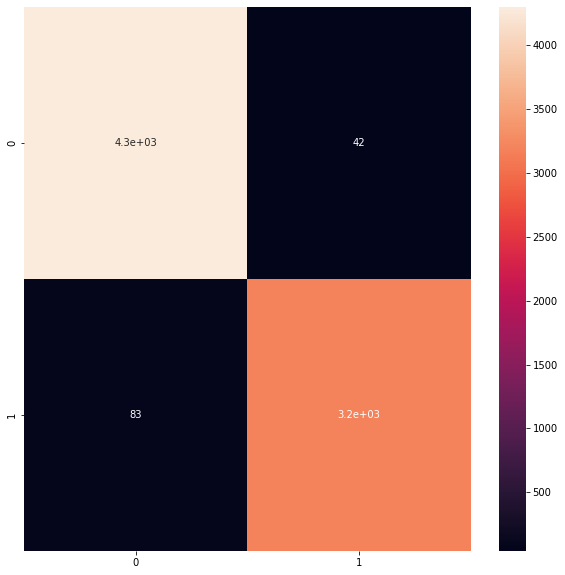

In [90]:
sns.heatmap(cm, annot=True)